In [19]:
import os
import pickle
import time
from itertools import repeat, combinations
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, RandomCrop, RandomHorizontalFlip, RandomRotation, ColorJitter, CenterCrop, ToTensor, Normalize, Compose
from torchvision.models import resnet18, resnet50

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image as PILImage
from PIL import ImageStat as PILImageStat

pd.options.mode.chained_assignment = None

name = 'parkers_brook'
data_dir = 'data'

site_dir = os.path.join(data_dir, name)
images_dir =  os.path.join(site_dir, 'images')
model_dir =  os.path.join(site_dir, 'model')
pred_dir =  os.path.join(site_dir, 'pred')

os.makedirs(model_dir, exist_ok=True)
os.makedirs(pred_dir, exist_ok=True)

In [2]:
df = pd.read_csv(os.path.join(site_dir, 'images.csv'), dtype={'flow_cfs': np.float32})
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_convert(tz='US/Eastern')
df['week'] = df['timestamp'].dt.isocalendar().week
df['year'] = df['timestamp'].dt.isocalendar().year
df.sort_values(by='timestamp', inplace=True, ignore_index=True)
df = df.sample(500, replace=False)
df

,filename,timestamp,flow_cfs,week,year
5434,20190913_1600_ParkersBrook.jpg,2019-09-13 12:00:00-04:00,4.710000,37,2019
2290,20181213_1600_ParkersBrook.JPG,2018-12-13 11:00:00-05:00,13.550000,50,2018
5182,20190816_1600_ParkersBrook.jpg,2019-08-16 12:00:00-04:00,3.280000,33,2019
4654,20190627_1300_ParkersBrook.jpg,2019-06-27 09:00:00-04:00,7.200000,26,2019
4890,20190715_1500_ParkersBrook.jpg,2019-07-15 11:00:00-04:00,4.190000,29,2019
...,...,...,...,...,...
1938,20181111_0700_ParkersBrook.JPG,2018-11-11 02:00:00-05:00,22.120001,45,2018
3696,20190414_1700_ParkersBrook.jpg,2019-04-14 13:00:00-04:00,18.430000,15,2019
2166,20181201_1200_ParkersBrook.JPG,2018-12-01 07:00:00-05:00,19.770000,48,2018
218,20180701_0800_ParkersBrook.JPG,2018-07-01 04:00:00-04:00,14.140000,26,2018


In [3]:
df.dtypes

filename                         object
timestamp    datetime64[ns, US/Eastern]
flow_cfs                        float32
week                             UInt32
year                             UInt32
dtype: object

In [4]:
weekly_flow_means = df[['flow_cfs', 'year', 'week']].groupby(['year', 'week']).mean().rename(columns={'flow_cfs': 'mean_flow_cfs'})
weekly_flow_means.head()

mean_flow_cfs
year week               
2018 24         3.912857
     25         4.093846
     26        19.062500
     27        11.727500
     28         9.454000

In [5]:
weekly_flow_quantiles = np.quantile(weekly_flow_means['mean_flow_cfs'].values, [.25, .75], axis=0)
weekly_flow_quantiles

array([ 6.52437484, 16.4937501 ])

In [6]:
def classify(low_value, high_value, value):
    if value <= low_value:
        return 'low'
    elif value >= high_value:
        return 'high'
    else:
        return 'med'

weekly_flow_means['flow_class'] = weekly_flow_means['mean_flow_cfs'].map(lambda x: classify(weekly_flow_quantiles[0], weekly_flow_quantiles[1], x))
weekly_flow_means['week_index'] = range(len(weekly_flow_means.index))

weekly_flow_means.head()

mean_flow_cfs flow_class  week_index
year week                                      
2018 24         3.912857        low           0
     25         4.093846        low           1
     26        19.062500       high           2
     27        11.727500        med           3
     28         9.454000        med           4

In [7]:
df_week = df.set_index(['year', 'week']).join(weekly_flow_means, on=['year', 'week']).reset_index()
df_week

,year,week,filename,timestamp,flow_cfs,mean_flow_cfs,flow_class,week_index
0,2019,37,20190913_1600_ParkersBrook.jpg,2019-09-13 12:00:00-04:00,4.710000,4.861000,low,65
1,2018,50,20181213_1600_ParkersBrook.JPG,2018-12-13 11:00:00-05:00,13.550000,13.664445,med,26
2,2019,33,20190816_1600_ParkersBrook.jpg,2019-08-16 12:00:00-04:00,3.280000,3.316154,low,61
3,2019,26,20190627_1300_ParkersBrook.jpg,2019-06-27 09:00:00-04:00,7.200000,7.444286,med,54
4,2019,29,20190715_1500_ParkersBrook.jpg,2019-07-15 11:00:00-04:00,4.190000,5.205000,low,57
...,...,...,...,...,...,...,...,...
495,2018,45,20181111_0700_ParkersBrook.JPG,2018-11-11 02:00:00-05:00,22.120001,21.025000,high,21
496,2019,15,20190414_1700_ParkersBrook.jpg,2019-04-14 13:00:00-04:00,18.430000,17.440001,high,43
497,2018,48,20181201_1200_ParkersBrook.JPG,2018-12-01 07:00:00-05:00,19.770000,23.534286,high,24
498,2018,26,20180701_0800_ParkersBrook.JPG,2018-07-01 04:00:00-04:00,14.140000,19.062500,high,2


In [8]:
def image_resize(im, shape=None, scale=None): 
    if shape is None:
        r,c = im.size
        shape = (int(r*scale),int(c*scale))
    resized = im.resize(shape)
    return resized

# n_images = 100
# for filename in tqdm(df.head(n_images)['filename'], total=n_images):
#     raw_path = os.path.join(images_dir, filename)
#     new_path = os.path.join(resized_dir, filename)
#     if not os.path.exists(new_path):
#         image_resize(PILImage.open(raw_path), shape=(640,480)).save(new_path)

In [9]:
# df_week['rgb_mean'] = [
#     np.mean(PILImageStat.Stat(PILImage.open(os.path.join(images_dir, filename))).mean)
#     for filename in tqdm(df_week['filename'].values)
# ]
# df_week['rgb_mean'].hist()

In [10]:
min_hour = 7
max_hour = 18
df_week_filter = df_week[df_week['timestamp'].dt.hour.between(min_hour, max_hour)]
        
min_month = 1
max_month = 12
df_week_filter = df_week_filter[df_week_filter['timestamp'].dt.month.between(min_month, max_month)]

# min_rgb = 90
# df_week_filter = df_week_filter[df_week_filter['rgb_mean'] >= min_rgb]

len(df_week_filter) / len(df_week)

0.628

In [11]:
# weeks = avery.table[['flow_class', 'year', 'week', 'week_index']].drop_duplicates()
weeks = weekly_flow_means.reset_index()
random_seed = 12
test_ratio = 0.1
val_ratio = 0.1

X = weeks['week_index']
y = weeks['flow_class']

sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=random_seed)
trainval_idx, test_idx = list(sss_test.split(X, y))[0]
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio / (1 - test_ratio), random_state=random_seed)
train_idx, val_idx = list(sss_test.split(trainval_idx, y[trainval_idx]))[0]

weeks['split'] = weeks['week_index'].map(lambda x: 'train' if x in trainval_idx[train_idx] else 'val' if x in trainval_idx[val_idx] else 'test')
weeks.head(10)

,year,week,mean_flow_cfs,flow_class,week_index,split
0,2018,24,3.912857,low,0,test
1,2018,25,4.093846,low,1,train
2,2018,26,19.062500,high,2,train
3,2018,27,11.727500,med,3,train
4,2018,28,9.454000,med,4,val
5,2018,29,11.035556,med,5,train
6,2018,30,15.983750,med,6,train
7,2018,31,13.425000,med,7,val
8,2018,32,14.254286,med,8,train
9,2018,33,23.967142,high,9,train


In [12]:
weeks.groupby(['flow_class']).size() / len(weeks.index) * 100

flow_class
high    25.0
low     25.0
med     50.0
dtype: float64

In [13]:
weeks.groupby(['split', 'flow_class']).size()

split  flow_class
test   high           2
       low            2
       med            4
train  high          14
       low           14
       med           29
val    high           2
       low            2
       med            3
dtype: int64

In [14]:
df_train = df_week_filter[df_week_filter['week_index'].isin(trainval_idx[train_idx])]
df_val = df_week_filter[df_week_filter['week_index'].isin(trainval_idx[val_idx])]
df_test = df_week_filter[df_week_filter['week_index'].isin(test_idx)]
len(df_train), len(df_val), len(df_test)

(244, 38, 32)

In [15]:
df_train.groupby('flow_class').size()

flow_class
high     54
low      61
med     129
dtype: int64

In [16]:
df_test.groupby('flow_class').size()

flow_class
high     8
low      6
med     18
dtype: int64

In [17]:
f_val.groupby('flow_class').size()

flow_class
high    10
low     12
med     16
dtype: int64

In [50]:
class ImagePairSampler:
    """Sampling methods for pairs of streamflow images."""
    def __init__(self, table, sampling_fn):
        self.table = table
        self.pair_sampling_fn = sampling_fn
    
    def get_pairs(self, num_pairs):
        return self.pair_sampling_fn(self.table, num_pairs)

def random_pairs(table, num_pairs):
    # each image is paired with another image at random
    all_img_idx_combinations = list(combinations(range(len(table)), 2))
    num_combinations = len(all_img_idx_combinations)
    if len(all_img_idx_combinations) < num_pairs:
        combinations_sample = [all_img_idx_combinations[i] for i in np.random.choice(range(num_combinations), num_pairs, replace=True)]
    else:
        combinations_sample = [all_img_idx_combinations[i] for i in np.random.choice(range(num_combinations), num_pairs, replace=False)]
    return combinations_sample

class SiteDataset(Dataset):
    def __init__(self, table, images_dir, resize_size=[480,640], crop_size=[384,512],
                normalize=True, augment=True, training=True, means=None, stds=None, 
                crop_to_bbox=False, log_transform=False):
        self.table = table
        self.images_dir = images_dir
        self.resize_size = resize_size
        self.crop_size = crop_size
        self.normalize = normalize
        self.augment = augment
        self.training = training
        self.crop_to_bbox = crop_to_bbox
        self.log_transform = log_transform
        self.image_pair_sampler = None
        self.ranked_image_pairs = []
    
    def __len__(self):
        return len(self.ranked_image_pairs)
    
    def get_image(self, index):
        """Loads image at given index"""
        path = os.path.join(images_dir, self.table.iloc[index]['filename'])
        return PILImage.open(path).convert('RGB')
    
    def compute_mean_std(self):
        """Compute RGB channel means and stds for image samples in the dataset."""
        means = np.zeros((3))
        stds = np.zeros((3))
        sample_size= min(len(self.table), 1000)
        sample_indices = np.random.choice(len(self.table), size=sample_size, replace=False)
        for idx in tqdm(sample_indices):
            img = self.get_image(idx)
            stat = PILImageStat.Stat(img)
            means += np.array(stat.mean)/255.0
            stds += np.array(stat.stddev)/255.0
        means = means/sample_size
        stds = stds/sample_size
        return means, stds
    
    def set_mean_std(self, means, stds):
        self.means = means
        self.stds = stds
    
    def crop_images_to_bboxes(self, crop_bool):
        self.crop_to_bbox = crop_bool
    
    def set_bbox_source(self, filename):
        self.bbox_file = filename
        with open(filename, 'rb') as handle:
            self.bboxes = pickle.load(handle)
    
    def create_transforms(self):
        """Create transforms to apply during training and evaluation.
        Transforms can involve data augmentation and/or normalization if desired.
        Data augmentation should only be applied during training, not during evaluation.
        """
        train_transforms = [Resize(self.resize_size)]
        if self.augment:
            train_transforms.append(RandomCrop(self.crop_size))
            train_transforms.append(RandomHorizontalFlip())
            train_transforms.append(RandomRotation(10))
            train_transforms.append(ColorJitter())
        else:
            train_transforms.append(CenterCrop(self.crop_size))
        train_transforms.append(ToTensor())
        if self.normalize:
            train_transforms.append(Normalize(self.means, self.stds))
        self.train_transform = Compose(train_transforms)
        
        eval_transforms = [Resize(self.resize_size)]
        eval_transforms.append(CenterCrop(self.crop_size))
        eval_transforms.append(ToTensor())
        if self.normalize:
            eval_transforms.append(Normalize(self.means, self.stds))
        self.eval_transform = Compose(eval_transforms)
    
    def train(self):
        self.training = True
    
    def evaluate(self):
        self.training = False

    def rank_image_pairs(self, pair_sampling_fn, num_pairs, margin=0):
        self.image_pair_sampler = ImagePairSampler(self.table, pair_sampling_fn)
        self.sampled_image_pairs = self.image_pair_sampler.get_pairs(num_pairs)
        labeled_sampled_image_pairs = self.label_image_pairs(self.sampled_image_pairs, margin=margin)
        self.ranked_image_pairs.extend(labeled_sampled_image_pairs)
        
    def label_image_pairs(self, image_pairs, margin, mode='relative'):
        labeled_ranked_image_pairs = []
        for i in range(len(image_pairs)):
            idx1 = image_pairs[i][0]
            idx2 = image_pairs[i][1]
            if mode == 'absolute':
                if (self.table['flow_cfs'].iloc[idx1] - self.table['flow_cfs'].iloc[idx2]) > margin:
                    # first idx has higher discharge
                    label = 1
                elif (self.table['flow_cfs'].iloc[idx1] - self.table['flow_cfs'].iloc[idx2]) < -margin:
                    # first idx has lower discharge
                    label = -1
                else:
                    # both indices have similar discharge
                    label = 0
            elif mode == 'relative':
                left_disch = self.table['flow_cfs'].iloc[idx1]
                right_dishc = self.table['flow_cfs'].iloc[idx2]
                min_disch = min(left_disch, right_dishc)
                if (left_disch - right_dishc)/min_disch > margin:
                    # first idx has higher discharge
                    label = 1
                elif (left_disch - right_dishc)/min_disch < -margin:
                    # first idx has lower discharge
                    label = -1
                else:
                    # both indices have similar discharge
                    label = 0
            labeled_ranked_image_pairs.extend([(idx1, idx2, label), (idx2, idx1, -1*label)])
        return labeled_ranked_image_pairs
    
    def __getitem__(self, idx):
        idx1, idx2, label = self.ranked_image_pairs[idx]
        img1 = self.get_image(idx1)
        img2 = self.get_image(idx2)

        # crop images first
        if self.crop_to_bbox:
            image1_table_index = self.table.index[idx1]
            topleft_x_1, topleft_y_1, width_1, height_1 = self.bboxes[image1_table_index]
            bottomright_x_1 = topleft_x_1 + width_1
            bottomright_y_1 = topleft_y_1 + height_1
            img1 = img1.crop((topleft_x_1, topleft_y_1, bottomright_x_1, bottomright_y_1))

            image2_table_index = self.table.index[idx2]
            topleft_x_2, topleft_y_2, width_2, height_2 = self.bboxes[image2_table_index]
            bottomright_x_2 = topleft_x_2 + width_2
            bottomright_y_2 = topleft_y_2 + height_2
            img2 = img2.crop((topleft_x_2, topleft_y_2, bottomright_x_2, bottomright_y_2))

        # apply transforms
        if self.training:
            img1 = self.train_transform(img1)
            img2 = self.train_transform(img2)
        else:
            img1 = self.eval_transform(img1)
            img2 = self.eval_transform(img2)
        
        return img1, img2, label

# num_train_pairs = 5000
num_train_pairs = 1000
margin=0.1
ds_train = SiteDataset(df_train, images_dir, training=True, normalize=True, augment=True, log_transform=True)
ds_train.rank_image_pairs(random_pairs, num_pairs=num_train_pairs, margin=0.1)
ds_val = SiteDataset(df_val, images_dir, training=False, normalize=True, augment=True, log_transform=True)
ds_val.rank_image_pairs(random_pairs, num_pairs=num_train_pairs, margin=0.1)
ds_test = SiteDataset(df_test, images_dir, training=False, normalize=True, augment=True, log_transform=True)
ds_test.rank_image_pairs(random_pairs, num_pairs=num_train_pairs, margin=0.1)

In [51]:
def compute_mean_std(df):
    """Compute RGB channel means and stds for image samples in the dataset."""
    means = np.zeros((3))
    stds = np.zeros((3))
    sample_size= min(len(df), 1000)
    sample_indices = np.random.choice(len(df), size=sample_size, replace=False)
    for idx in tqdm(sample_indices):
        path = os.path.join(images_dir, df.iloc[idx]['filename'])
        img = PILImage.open(path).convert('RGB')
        stat = PILImageStat.Stat(img)
        means += np.array(stat.mean)/255.0
        stds += np.array(stat.stddev)/255.0
    means = means/sample_size
    stds = stds/sample_size
    return means, stds

m,s = compute_mean_std(df_train)
ds_train.set_mean_std(m, s)
ds_val.set_mean_std(m, s)
ds_test.set_mean_std(m, s)

  0%|          | 0/244 [00:00<?, ?it/s]

In [52]:
ds_train.create_transforms()
ds_val.create_transforms()
ds_test.create_transforms()

In [53]:
batch_size = 64
num_workers = 0
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=num_workers)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [54]:
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")
device = torch.device("cpu")
device

device(type='cpu')

In [55]:
def get_output_shape(model, input_shape=(1,3,224,224)):
    x = torch.randn(*input_shape)
    out = model(x)
    return out.shape

class ResNet18(nn.Module):
    """PyTorch ResNet-18 architecture.
    Attributes:
        pretrained (bool): whether to use weights from network trained on ImageNet
        truncate (int): how many layers to remove from the end of the network
    """
    def __init__(self, pretrained=True, truncate=0):
        super(ResNet18, self).__init__()
        self.model = resnet18(pretrained=pretrained)
        if truncate > 0:
            self.model = nn.Sequential(*list(self.model.children())[:-truncate])

        self.model.eval()

    def forward(self, x):
        x = self.model(x)
        return x

class ResNetRankNet(ResNetRegressionNet):
    """TODO:
        - Add docstrings
    """
    def __init__(self, input_shape=(3, 384, 512), resnet_size=50, truncate=2, pretrained=True, num_hlayers=[256, 64]):
        super().__init__(
            input_shape=input_shape,
            resnet_size=resnet_size,
            truncate=truncate,
            pretrained=pretrained,
            num_hlayers=num_hlayers
        )
    
    def forward_single(self, x):
        x = self.resnetbody(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fclayers(x)
        x = x.squeeze()
        return x
    
    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_single(input1)
        # forward pass of input 2
        output2 = self.forward_single(input2)
        # return the predicted feature vectors of both inputs
        return output1, output2


model = ResNetRankNet(input_shape=(3, 384, 512), resnet_size=18, truncate=2, pretrained=True)

/opt/homebrew/Caskroom/miniconda/base/envs/deepstreamflow/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/deepstreamflow/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
for p in list(model.children())[0].parameters():
    p.requires_grad = False
unfreeze_after = 2
# model = torch.nn.DataParallel(model)
model.to(device)

ResNetRankNet(
  (resnetbody): ResNet18(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, e

In [57]:
class MSELoss(nn.Module):
    def __init__(self):
        super(MSELoss, self).__init__()
        self.loss = nn.MSELoss()
    
    def forward(self, input, target):
        output = self.loss(input, target)
        return output

class RankNetLoss(nn.Module):
    def __init__(self):
        super(RankNetLoss, self).__init__()
    
    def forward(self, inputs_i, inputs_j, targets):
        oij = inputs_i - inputs_j
        Pij = torch.sigmoid(oij)
        target_probs = 0.5*(targets + 1)
        bceloss = nn.BCELoss()
        loss = bceloss(Pij, target_probs)
        return loss
    
criterion = RankNetLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

In [58]:
class PairwiseRankAccuracy(torch.nn.Module):
    def __init__(self):
        super(PairwiseRankAccuracy, self).__init__()
    
    def forward(self, outputs_i, outputs_j, targets, boundaries=[0.33, 0.66]):
        oij = outputs_i - outputs_j
        Pij = torch.sigmoid(oij)
        preds = torch.zeros_like(targets)
        preds = torch.where(Pij < boundaries[0], -1, preds)
        preds = torch.where(Pij > boundaries[1], 1, preds)
        # preds[(Pij>boundaries[1])] = 1
        # preds[(Pij<boundaries[0])] = -1
        total = targets.size(0)
        # correct = (preds == targets).sum()
        correct = torch.eq(preds, targets).sum()
        return 100*correct/float(total)
        # zeros = (Pij>=0.33).float()*(Pij<=0.66).float()
        # target_probs = 0.5*(targets + 1)

def fit(model, criterion, optimizer, train_dl, device, epoch_num=None, verbose=False):
    """Train model for one epoch.
    
    Args:
        model (torch.nn.Module): network to train
        criterion (torch.nn.Module): loss function(s) used to train network weights
        optimizer (torch.optim.Optimizer): algorithm used to optimize network weights
        train_dl (torch.utils.DataLoader): data loader for training set
        epoch_num (int): epoch number for logging
    
    Returns:
        batch_loss_logger.avg (float): average criterion loss per batch during training
    """
    print('Training')
    model.train() # ensure model is in train mode
    train_dl.dataset.train() # ensure train transforms are applied
    batch_loss_logger = MetricLogger()
    batch_time_logger = MetricLogger()
    
    for bidx, batch in tqdm(enumerate(train_dl), total=len(train_dl)):
        
        batch_starttime = time.time()
        
        if isinstance(criterion, (torch.nn.MarginRankingLoss, RankNetLoss)):
            # paired inputs ->[model]-> paired outputs ->[criterion]-> value
            inputs1, inputs2, labels = batch
            if next(model.parameters()).is_cuda:
                inputs1 = inputs1.to(device)
                inputs2 = inputs2.to(device)
                labels = labels.to(device)
            optimizer.zero_grad()
            outputs1, outputs2 = model(inputs1, inputs2)
            loss = criterion(outputs1, outputs2, labels)
            batch_loss_logger.update(loss.item())
            loss.backward()
            optimizer.step()
        else:
            # inputs ->[model]-> outputs ->[criterion]-> value
            inputs, labels = batch
            if next(model.parameters()).is_cuda:
                inputs = inputs.to(device)
                labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_loss_logger.update(loss.item())
            loss.backward()
            optimizer.step()
        
        batch_endtime = time.time()
        batch_time_logger.update(batch_endtime-batch_starttime)
        
        if verbose and (bidx%10 == 9):
            print(f"[Epoch {epoch_num} Batch {bidx}]\t{batch_time_logger.sum:.2f} s\t{batch_loss_logger.avg:.4f}")
    
    print(f"[Epoch {epoch_num}]\t{batch_time_logger.sum:.2f} s\t{batch_loss_logger.avg:.4f}")
    
    return batch_loss_logger.avg

def validate(model, criterions, dl, device):
    """Calculate multiple criterion for a model on a dataset."""
    print('Validating')
    model.eval()
    dl.dataset.evaluate()
    criterion_loggers = [MetricLogger() for i in range(len(criterions))]
    with torch.no_grad(): # ensure no gradients are computed
        for bidx, batch in tqdm(enumerate(dl), total=len(dl)):
            model_outputs = {}
            for i, c in enumerate(criterions):
                # start_timer = time.time()
                if isinstance(c, (torch.nn.MarginRankingLoss, RankNetLoss, PairwiseRankAccuracy)):
                    # paired inputs ->[model]-> paired outputs ->[criterion]-> value
                    if 'outputs1' not in model_outputs.keys():
                        # store model outputs from forward pass in case another criterion needs the same
                        inputs1, inputs2, labels = batch
                        if next(model.parameters()).is_cuda:
                            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
                        outputs1, outputs2 = model(inputs1, inputs2)
                        model_outputs['outputs1'] = outputs1
                        model_outputs['outputs2'] = outputs2
                    else:
                        # load previously computed model outputs from forward pass
                        outputs1, outputs2 = model_outputs['outputs1'], model_outputs['outputs2']
                    cval = c(outputs1, outputs2, labels)
                else:
                    # inputs ->[model]-> outputs ->[criterion]-> value
                    if 'outputs' not in model_outputs.keys():
                        # store model outputs from forward pass in case another criterion needs the same
                        inputs, labels = batch
                        if next(model.parameters()).is_cuda:
                            inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        model_outputs['outputs'] = outputs
                    else:
                        # load previously computed model outputs from forward pass
                        outputs = model_outputs['outputs']
                    cval = c(outputs, labels)
                criterion_loggers[i].update(cval.item())
    return [cl.avg for cl in criterion_loggers]

class MetricLogger(object):
    """Computes and tracks the average and current value of a metric.
    
    Attributes:
        val: current value
        sum: sum of all logged values
        count: number of logged values
        avg: average of all logged values
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.count += n
        self.sum += val * n
        self.avg = self.sum / self.count


In [59]:
metriclogs = {}
metriclogs['training_loss'] = []
metriclogs['val_loss'] = []
metriclogs['test_loss'] = []

paramstrings = []
paramstrings.append('ranking')
paramstrings.append(name)
paramstrings.append('augment')
paramstrings.append('normalize')
paramstr = '_'.join(paramstrings)

n_epochs = 10
for epoch in range(n_epochs):
    # train
    start_time = time.time()
    avg_loss_training = fit(model, criterion, optimizer, dl_train, device, epoch_num=epoch)
    stop_time = time.time()
    print('training epoch took %0.1f s'%(stop_time-start_time))
    metriclogs['training_loss'].append(avg_loss_training)

    # validate on val set
    start_time = time.time()
    valset_eval = validate(model, [criterion], dl_val, device)
    stop_time = time.time()
    print('valset eval took %0.1f s'%(stop_time-start_time))
    metriclogs['val_loss'].append(valset_eval[0])

    # validate on test set (peeking)
    start_time = time.time()
    testset_eval = validate(model, [criterion], dl_test, device)
    stop_time = time.time()
    print('testset eval took %0.1f s'%(stop_time-start_time))
    metriclogs['test_loss'].append(testset_eval[0])

    # update lr scheduler
    scheduler.step(valset_eval[0])

    # periodically save model checkpoints
    epoch_checkpoint_file = './epoch%d_'%epoch + paramstr + '.ckpt'
    epoch_checkpoint_save_path = os.path.join(model_dir, epoch_checkpoint_file)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_loss': avg_loss_training,
        }, epoch_checkpoint_save_path)

    #  after [unfreeze_after] epochs, unfreeze the pretrained body network parameters
    if (epoch+1) == unfreeze_after:
        print('UNFREEZING CNN BODY')
        for p in list(model.children())[0].parameters():
            p.requires_grad = True

# save losses and any other metrics tracked during training
metrics_file = 'metrics_per_epoch_'+ paramstr + '.pkl'
metrics_save_path = os.path.join('.', metrics_file)
with open(metrics_save_path, 'wb') as f:
    pickle.dump(metriclogs, f, protocol=pickle.HIGHEST_PROTOCOL)

Training


  0%|          | 0/32 [00:00<?, ?it/s]

[Epoch 0]	648.01 s	0.6897
training epoch took 833.6 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

valset eval took 2665.7 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

testset eval took 1806.5 s
Training


  0%|          | 0/32 [00:00<?, ?it/s]

[Epoch 1]	646.34 s	0.6757
training epoch took 831.8 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

valset eval took 818.2 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

testset eval took 819.0 s
UNFREEZING CNN BODY
Training


  0%|          | 0/32 [00:00<?, ?it/s]

[Epoch 2]	2133.29 s	0.6538
training epoch took 2323.5 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

valset eval took 1827.9 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

testset eval took 817.6 s
Training


  0%|          | 0/32 [00:00<?, ?it/s]

[Epoch 3]	1120.77 s	0.6072
training epoch took 1310.3 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

valset eval took 819.4 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

testset eval took 3775.9 s
Training


  0%|          | 0/32 [00:00<?, ?it/s]

[Epoch 4]	1117.74 s	0.5334
training epoch took 1306.2 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

valset eval took 819.8 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

testset eval took 822.0 s
Training


  0%|          | 0/32 [00:00<?, ?it/s]

[Epoch 5]	3119.73 s	0.4552
training epoch took 4228.2 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

valset eval took 821.0 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

testset eval took 820.4 s
Training


  0%|          | 0/32 [00:00<?, ?it/s]

[Epoch 6]	1122.37 s	0.3785
training epoch took 1311.7 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

valset eval took 1835.7 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

testset eval took 823.7 s
Training


  0%|          | 0/32 [00:00<?, ?it/s]

[Epoch 7]	1122.92 s	0.3159
training epoch took 1312.3 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

valset eval took 827.1 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

testset eval took 825.4 s
Training


  0%|          | 0/32 [00:00<?, ?it/s]

[Epoch 8]	2109.68 s	0.2690
training epoch took 3280.7 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

valset eval took 823.5 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

testset eval took 824.1 s
Training


  0%|          | 0/32 [00:00<?, ?it/s]

[Epoch 9]	1125.38 s	0.2407
training epoch took 1314.8 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

valset eval took 1112.6 s
Validating


  0%|          | 0/32 [00:00<?, ?it/s]

testset eval took 1741.2 s


In [62]:
df_metrics = pd.DataFrame(data=metriclogs)
df_metrics['epoch'] = df_metrics.index
df_metrics = df_metrics.set_index('epoch')
df_metrics

,training_loss,val_loss,test_loss
epoch,,,
0,0.689715,0.668377,0.676488
1,0.675683,0.639295,0.656151
2,0.653818,0.585750,0.618089
3,0.607151,0.512037,0.564023
4,0.533419,0.418085,0.492503
5,0.455228,0.337901,0.430797
6,0.378504,0.275959,0.383033
7,0.315896,0.237928,0.348559
8,0.269022,0.222659,0.320246


<AxesSubplot:xlabel='epoch'>

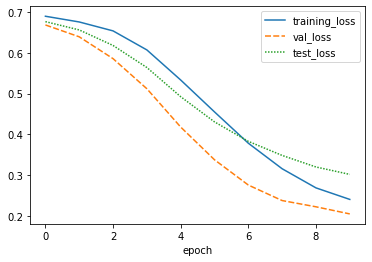

In [63]:
sns.lineplot(data=df_metrics)

In [71]:
class SiteDataset2(Dataset):
    def __init__(self, table, images_dir, resize_size=[480,640], crop_size=[384,512],
                normalize=True, augment=True, training=True, means=None, stds=None, 
                crop_to_bbox=False, log_transform=False):
        self.table = table
        self.images_dir = images_dir
        self.resize_size = resize_size
        self.crop_size = crop_size
        self.normalize = normalize
        self.augment = augment
        self.training = training
        self.crop_to_bbox = crop_to_bbox
        self.log_transform = log_transform
    
    def __len__(self):
        return len(self.table)
    
    def get_image(self, index):
        """Loads image at given index"""
        path = os.path.join(images_dir, self.table.iloc[index]['filename'])
        return PILImage.open(path).convert('RGB')
    
    def compute_mean_std(self):
        """Compute RGB channel means and stds for image samples in the dataset."""
        means = np.zeros((3))
        stds = np.zeros((3))
        sample_size= min(len(self.table), 1000)
        sample_indices = np.random.choice(len(self.table), size=sample_size, replace=False)
        for idx in tqdm(sample_indices):
            img = self.get_image(idx)
            stat = PILImageStat.Stat(img)
            means += np.array(stat.mean)/255.0
            stds += np.array(stat.stddev)/255.0
        means = means/sample_size
        stds = stds/sample_size
        return means, stds
    
    def set_mean_std(self, means, stds):
        self.means = means
        self.stds = stds
    
    def crop_images_to_bboxes(self, crop_bool):
        self.crop_to_bbox = crop_bool
    
    def set_bbox_source(self, filename):
        self.bbox_file = filename
        with open(filename, 'rb') as handle:
            self.bboxes = pickle.load(handle)
    
    def create_transforms(self):
        """Create transforms to apply during training and evaluation.
        Transforms can involve data augmentation and/or normalization if desired.
        Data augmentation should only be applied during training, not during evaluation.
        """
        train_transforms = [Resize(self.resize_size)]
        if self.augment:
            train_transforms.append(RandomCrop(self.crop_size))
            train_transforms.append(RandomHorizontalFlip())
            train_transforms.append(RandomRotation(10))
            train_transforms.append(ColorJitter())
        else:
            train_transforms.append(CenterCrop(self.crop_size))
        train_transforms.append(ToTensor())
        if self.normalize:
            train_transforms.append(Normalize(self.means, self.stds))
        self.train_transform = Compose(train_transforms)
        
        eval_transforms = [Resize(self.resize_size)]
        eval_transforms.append(CenterCrop(self.crop_size))
        eval_transforms.append(ToTensor())
        if self.normalize:
            eval_transforms.append(Normalize(self.means, self.stds))
        self.eval_transform = Compose(eval_transforms)
    
    def train(self):
        self.training = True
    
    def evaluate(self):
        self.training = False
    
    def __getitem__(self, idx):
        img = self.get_image(idx)
        # crop image first
        if self.crop_to_bbox:
            image_table_index = self.table.index[idx]
            topleft_x, topleft_y, width, height = self.bboxes[image_table_index]
            bottomright_x = topleft_x + width
            bottomright_y = topleft_y + height
            img = img.crop((topleft_x, topleft_y, bottomright_x, bottomright_y))
        
        # apply transforms
        if self.training:
            sample = self.train_transform(img)
        else:
            sample = self.eval_transform(img)
        if not self.log_transform:
            label = self.table.iloc[idx]['flow_cfs']
        else:
            label = np.log(self.table.iloc[idx]['flow_cfs'])
        return sample, label

ds_train2 = SiteDataset2(df_train, images_dir, training=False, normalize=True, augment=True, log_transform=True)
ds_val2 = SiteDataset2(df_val, images_dir, training=False, normalize=True, augment=True, log_transform=True)
ds_test2 = SiteDataset2(df_test, images_dir, training=False, normalize=True, augment=True, log_transform=True)

m,s = ds_train2.compute_mean_std()
ds_train2.set_mean_std(m, s)
ds_val2.set_mean_std(m, s)
ds_test2.set_mean_std(m, s)

ds_train2.create_transforms()
ds_val2.create_transforms()
ds_test2.create_transforms()

  0%|          | 0/244 [00:00<?, ?it/s]

In [72]:
dl_train2 = DataLoader(ds_train2, batch_size=batch_size, shuffle=False, num_workers=0)
dl_val2 = DataLoader(ds_val2, batch_size=batch_size, shuffle=False, num_workers=0)
dl_test2 = DataLoader(ds_test2, batch_size=batch_size, shuffle=False, num_workers=0)

In [77]:
model = ResNetRankNet(input_shape=(3, 384, 512), resnet_size=18, truncate=True, pretrained=True)
model.to(device)
ckpt_path = os.path.join(model_dir, f'epoch{n_epochs - 1}_.ckpt')
checkpoint = torch.load(ckpt_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

/opt/homebrew/Caskroom/miniconda/base/envs/deepstreamflow/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/deepstreamflow/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNetRankNet(
  (resnetbody): ResNet18(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, e

In [83]:
for dl in [dl_train2, dl_val2, dl_test2]:
        dl.dataset.evaluate()
        scores = np.empty((len(dl.dataset),))
        sidx = 0
        with torch.no_grad():
            for bidx, batch in tqdm(enumerate(dl), total=len(dl)):
                inputs, labels = batch
                nsamples = labels.shape[0]
                outputs = model.forward_single(inputs.to(device))
                scores[sidx:sidx+nsamples] = outputs.detach().cpu().numpy()
                sidx += nsamples
        dl.dataset.table.loc[:,'scores'] = scores

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [84]:
train_pred_f = 'rank_pred_train.csv'
train_pred_save_path = os.path.join(pred_dir, train_pred_f)
dl_train2.dataset.table.to_csv(train_pred_save_path)

val_pred_f = 'rank_pred_val.csv'
val_pred_save_path = os.path.join(pred_dir, val_pred_f)
dl_val2.dataset.table.to_csv(val_pred_save_path)

test_pred_f = 'rank_pred_test.csv'
test_pred_save_path = os.path.join(pred_dir, test_pred_f)
dl_test2.dataset.table.to_csv(test_pred_save_path)

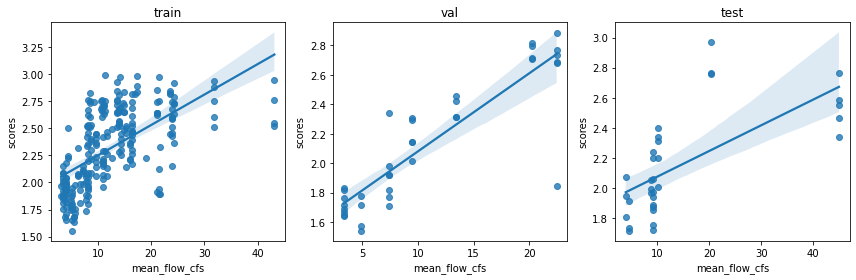

In [85]:
f, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.regplot(x=dl_train2.dataset.table.mean_flow_cfs, y=dl_train2.dataset.table.scores, ax=axs[0]).set(title="train")
sns.regplot(x=dl_val2.dataset.table.mean_flow_cfs, y=dl_val2.dataset.table.scores, ax=axs[1]).set(title="val")
sns.regplot(x=dl_test2.dataset.table.mean_flow_cfs, y=dl_test2.dataset.table.scores, ax=axs[2]).set(title="test")
f.tight_layout()

In [86]:
dl_train2.dataset.table

,year,week,filename,timestamp,flow_cfs,mean_flow_cfs,flow_class,week_index,preds,scores
0,2019,37,20190913_1600_ParkersBrook.jpg,2019-09-13 12:00:00-04:00,4.71,4.861000,low,65,5.981685,1.788702
1,2018,50,20181213_1600_ParkersBrook.JPG,2018-12-13 11:00:00-05:00,13.55,13.664445,med,26,14.109397,2.646841
4,2019,29,20190715_1500_ParkersBrook.jpg,2019-07-15 11:00:00-04:00,4.19,5.205000,low,57,4.721005,1.552022
6,2019,12,20190318_1500_ParkersBrook.jpg,2019-03-18 11:00:00-04:00,13.47,16.500000,high,40,9.960950,2.298672
8,2019,13,20190327_1200_ParkersBrook.jpg,2019-03-27 08:00:00-04:00,12.18,14.991428,med,41,11.971056,2.482492
...,...,...,...,...,...,...,...,...,...,...
484,2019,32,20190810_1600_ParkersBrook.jpg,2019-08-10 12:00:00-04:00,3.25,3.954286,low,60,6.807398,1.918010
487,2019,42,20191019_1600_ParkersBrook.jpg,2019-10-19 12:00:00-04:00,5.14,8.661250,med,70,10.832361,2.382538
491,2019,43,20191021_1200_ParkersBrook.jpg,2019-10-21 08:00:00-04:00,4.65,4.417500,low,71,9.403910,2.241126
496,2019,15,20190414_1700_ParkersBrook.jpg,2019-04-14 13:00:00-04:00,18.43,17.440001,high,43,19.686080,2.979912


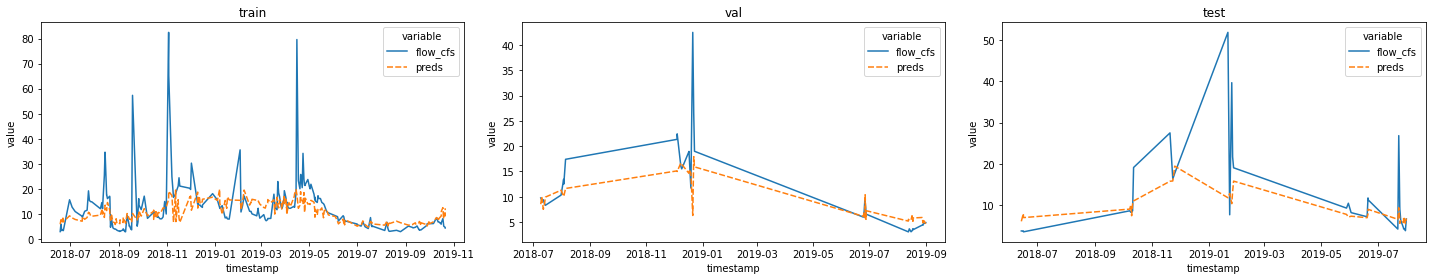

In [90]:
f, axs = plt.subplots(1, 3, figsize=(20, 4))
sns.lineplot(data=dl_train2.dataset.table.melt(id_vars=["timestamp"], value_vars=["flow_cfs","preds"]), x="timestamp", y="value", hue="variable", style="variable", linestyle="", ax=axs[0]).set(title="train")
sns.lineplot(data=dl_val2.dataset.table.melt(id_vars=["timestamp"], value_vars=["flow_cfs","preds"]), x="timestamp", y="value", hue="variable", style="variable", linestyle="", ax=axs[1]).set(title="val")
sns.lineplot(data=dl_test2.dataset.table.melt(id_vars=["timestamp"], value_vars=["flow_cfs","preds"]), x="timestamp", y="value", hue="variable", style="variable", linestyle="", ax=axs[2]).set(title="test")
f.tight_layout()